In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from src.ds import Dataset, collate_fn
from torch.utils.data import DataLoader
import time

Intentando acelerar el data loading...

In [3]:
train = pd.read_json('data/train.json')

In [164]:
ds = Dataset(
	train.filename.values, 
	(0, 1),
	(2,1,0), 
	['September', 'October', 'November', 'December'], #, 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August'], 
	train.label.values
)

In [166]:
# measure time to load data

results = []
num_batches = 100
for bs in [1, 2, 4, 8, 16]: #, 32, 64]:
	dl = DataLoader(ds, batch_size=bs, shuffle=True, num_workers=10, pin_memory=True, collate_fn=collate_fn)
	start = time.time()
	for i, batch in enumerate(dl):
		(s1, s2), y = batch
		s1, s2 = s1.cuda(), s2.cuda()
		# s1, s2 = s1.cuda(non_blocking=True), s2.cuda(non_blocking=True)
		if i == num_batches:
			break
	end = time.time()
	print(f'100 batches loaded in {end-start:.2f} seconds')
	results.append((bs, end-start))

100 batches loaded in 0.75 seconds
100 batches loaded in 1.09 seconds
100 batches loaded in 1.72 seconds
100 batches loaded in 3.07 seconds
100 batches loaded in 6.84 seconds


In [167]:
results = pd.DataFrame(results, columns=['batch_size', 'time'])
# results.to_csv('benchmarks/ds1.csv', index=False)
results 

,batch_size,time
0,1,0.747518
1,2,1.085573
2,4,1.718430
3,8,3.071802
4,16,6.835647


In [200]:
import numpy as np 
from skimage.io import imread
import cupy as cp

class ExternalInputIterator(object):
    def __init__(self, images, labels, s1_bands, s2_bands, months, batch_size):
        self.batch_size = batch_size
        self.images = images
        self.labels = labels
        self.months = months
        self.s1_bands = s1_bands
        self.s2_bands = s2_bands

    def __iter__(self):
        self.i = 0
        self.n = len(self.images)
        return self

    def __next__(self):
        batch1, batch2, labels = [], [], []
        for _ in range(self.batch_size):
            s1s, s2s = [], []
            for month in self.months:
                path = self.images[self.i]['S1'][month]
                if path is None:
                    im = np.zeros((256, 256, len(self.s2_bands)))
                else:
                    im = imread(path)[..., self.s1_bands]
                    im = np.clip(im, -30, 0)*(-8.4) / 255.
                s1s.append(cp.asarray(im).astype(cp.float32))
                path = self.images[self.i]['S2'][month]
                if path is None:
                    im = np.zeros((256, 256, len(self.s2_bands)))
                else:
                    im = imread(path)
                    im = np.clip(im / 4000, 0, 1)[..., self.s2_bands]
                s2s.append(cp.asarray(im).astype(cp.float32))
            im1, im2 = cp.stack(s1s, axis=0), cp.stack(s2s, axis=0)
            batch1.append(im1)
            batch2.append(im2)
            labels.append(cp.asarray(imread(self.labels[self.i])).astype(cp.float32))
            self.i = (self.i + 1) % self.n
        return (batch1, batch2, labels)

    def __len__(self):
        return self.data_set_len

    next = __next__

In [201]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types

batch_size = 4
months = ['April', 'May', 'June'] # 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
eii = ExternalInputIterator(
	train.filename.values, 
	train.label.values, 
	(0, 1),
	(2,1,0), 
	months,
	batch_size
)

s1s, s2s, labels = next(iter(eii))


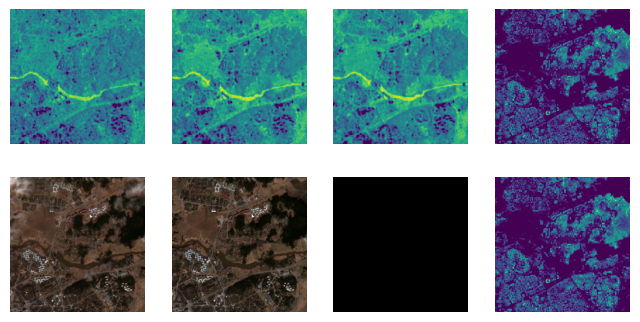

In [202]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(2, 4, 1)
ax.imshow(s1s[1][0].get()[...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 2)
ax.imshow(s1s[1][1].get()[...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 3)
ax.imshow(s1s[1][2].get()[...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 4)
ax.imshow(labels[1].get())
ax.axis('off')
ax = fig.add_subplot(2, 4, 5)
ax.imshow(s2s[1][0].get())
ax.axis('off')
ax = fig.add_subplot(2, 4, 6)
ax.imshow(s2s[1][1].get())
ax.axis('off')
ax = fig.add_subplot(2, 4, 7)
ax.imshow(s2s[1][2].get())
ax.axis('off')
ax = fig.add_subplot(2, 4, 8)
ax.imshow(labels[1].get())
ax.axis('off')
plt.show()

In [203]:
pipe = Pipeline(batch_size=batch_size, num_threads=2, device_id=0)
with pipe:
    tifs1, tifs2, labels = fn.external_source(source=eii, num_outputs=3, device="gpu", dtype=types.FLOAT)
    pipe.set_outputs(tifs1, tifs2, labels)

pipe.build()

In [204]:
pipe_out = pipe.run()
pipe_out

(TensorListGPU(
     [[[[[0.48721042 0.767506  ]
         [0.46052969 0.7643824 ]
         ...
         [0.59312135 0.98294306]
         [0.5904128  0.9667046 ]]
 
        [[0.46518072 0.76674855]
         [0.45733082 0.7585247 ]
         ...
         [0.59488297 0.9228638 ]
         [0.5950019  0.8660443 ]]
 
        ...
 
        [[0.43011957 0.59292084]
         [0.43195453 0.5863047 ]
         ...
         [0.48425165 0.74594516]
         [0.53776336 0.8156929 ]]
 
        [[0.48075733 0.6419739 ]
         [0.45753607 0.64829427]
         ...
         [0.49862906 0.82249933]
         [0.48709345 0.7928873 ]]]
 
 
       [[[0.36797604 0.603414  ]
         [0.37412283 0.62824166]
         ...
         [0.38282737 0.6617007 ]
         [0.39075834 0.6530902 ]]
 
        [[0.373189   0.59467155]
         [0.36372924 0.60666686]
         ...
         [0.35989207 0.6268746 ]
         [0.3638165  0.61116475]]
 
        ...
 
        [[0.34770933 0.50986403]
         [0.36409938 0.4979763 ]

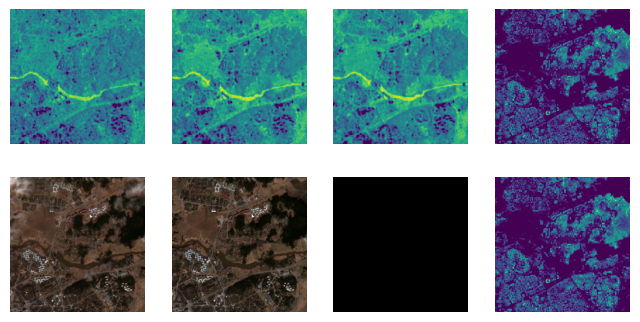

In [205]:
s1s, s2s, labels = pipe_out
s1s, s2s, labels = s1s.as_cpu(), s2s.as_cpu(), labels.as_cpu()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(2, 4, 1)
ax.imshow(s1s.at(1)[0][...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 2)
ax.imshow(s1s.at(1)[1][...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 3)
ax.imshow(s1s.at(1)[2][...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 4)
ax.imshow(labels.at(1))
ax.axis('off')
ax = fig.add_subplot(2, 4, 5)
ax.imshow(s2s.at(1)[0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 6)
ax.imshow(s2s.at(1)[1])
ax.axis('off')
ax = fig.add_subplot(2, 4, 7)
ax.imshow(s2s.at(1)[2])
ax.axis('off')
ax = fig.add_subplot(2, 4, 8)
ax.imshow(labels.at(1))
ax.axis('off')
plt.show()

In [206]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator

results = []
num_batches = 100
months = ['September', 'October', 'November', 'December'] # 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
for bs in [1, 2, 4, 8, 16]: #, 32, 64]:
	eii = ExternalInputIterator(
		train.filename.values, 
		train.label.values, 
		(0, 1),
		(2,1,0), 
		months,
		bs
	)
	pipe = Pipeline(batch_size=bs, num_threads=10, device_id=0)
	with pipe:
		tifs1, tifs2, labels = fn.external_source(source=eii, num_outputs=3, device="gpu", dtype=types.FLOAT)
		pipe.set_outputs(tifs1, tifs2, labels)
	pipe.build()
	# start = time.time()
	# for _ in range(num_batches):
	# 	pipe.run()
	pii = DALIGenericIterator([pipe], ['s1s', 's2s', 'labels'])
	start = time.time()
	for i, data in enumerate(pii):
		batch_data = data[0]
		s1s, s2s, labels = batch_data["s1s"], batch_data["s2s"], batch_data["labels"]
		if i == num_batches:
			# print(s1s.shape, s1s.device)
			break
	end = time.time()
	print(f'100 batches loaded in {end-start:.2f} seconds')
	results.append((bs, end-start))

100 batches loaded in 1.62 seconds
100 batches loaded in 3.21 seconds
100 batches loaded in 6.06 seconds
100 batches loaded in 12.05 seconds
100 batches loaded in 24.10 seconds


In [10]:
from cucim import CuImage

img = CuImage(train.filename.values[0]['S1']['September'])

img.shape, img.is_loaded, img.device

([256, 256, 4], True, cpu)

In [14]:
resolutions = img.resolutions
level_dimensions = resolutions["level_dimensions"]
level_count = resolutions["level_count"]
x = img.read_region(location=[0,0], size=level_dimensions[level_count - 1], level=level_count - 1)

x

RuntimeError: This format (compression: 1, sample_per_pixel: 4, planar_config: 1, photometric: 1) is not supported yet!: Sorry, can not handle images with 32-bit samples

In [19]:
from nvidia.dali.pipeline import Pipeline

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

image_dir = "data/train_features_npy"
max_batch_size = 8


@pipeline_def
def simple_pipeline():
    images = fn.readers.numpy(file_root=image_dir)
    return images

pipe = simple_pipeline(batch_size=max_batch_size, num_threads=1, device_id=0)
pipe.build()

In [20]:
pipe_out = pipe.run()
pipe_out

(TensorListCPU(
     [[[[0.42642784 0.60205966 0.5142437 ]
        [0.46515542 0.6599043  0.5625299 ]
        ...
        [0.29797798 0.5564118  0.42719486]
        [0.30800146 0.56191474 0.43495813]]
 
       [[0.44248462 0.63242173 0.53745323]
        [0.4735455  0.69412774 0.5838366 ]
        ...
        [0.31310946 0.5612534  0.4371814 ]
        [0.33922395 0.5804157  0.45981985]]
 
       ...
 
       [[0.36348388 0.5430358  0.4532599 ]
        [0.3672495  0.5442546  0.45575204]
        ...
        [0.3952591  0.5477305  0.47149482]
        [0.36543268 0.56297034 0.4642015 ]]
 
       [[0.38546023 0.59100145 0.48823082]
        [0.3808958  0.597639   0.4892674 ]
        ...
        [0.39770922 0.5592405  0.4784749 ]
        [0.39180785 0.556085   0.4739464 ]]]
 
 
      [[[0.39542863 0.64275837 0.51909345]
        [0.41169363 0.655473   0.53358334]
        ...
        [0.3334917  0.57787025 0.455681  ]
        [0.33702204 0.59604675 0.46653438]]
 
       [[0.38069034 0.6191727  0.